#***LSTM***

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# Load the data
df = pd.read_csv('BNB.csv')

# Preprocess the data
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
scaler = MinMaxScaler()
df['Normalized_Close'] = scaler.fit_transform(df['Close'].values.reshape(-1, 1))

# Function to create dataset for LSTM
def create_dataset(dataset, look_back=1):
    X, y = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:i + look_back]
        X.append(a)
        y.append(dataset[i + look_back])
    return np.array(X), np.array(y)

# Evaluate LSTM model with different train-val-test splits
for train_val_test_split in [(0.8, 0.1, 0.1), (0.7, 0.2, 0.1), (0.6, 0.2, 0.2)]:
    train_size = int(len(df) * train_val_test_split[0])
    val_size = int(len(df) * train_val_test_split[1])
    test_size = int(len(df) * train_val_test_split[2])

    train_data = df.iloc[:train_size, :]
    val_data = df.iloc[train_size:train_size+val_size, :]
    test_data = df.iloc[train_size+val_size:, :]

    X_train, y_train = create_dataset(train_data['Normalized_Close'].values, look_back=1)
    X_val, y_val = create_dataset(val_data['Normalized_Close'].values, look_back=1)
    X_test, y_test = create_dataset(test_data['Normalized_Close'].values, look_back=1)

    X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
    X_val = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1]))
    X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

    # Build and train the LSTM model
    model = Sequential()
    model.add(LSTM(50, input_shape=(1, 1)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), verbose=1)

    # Evaluate the model
    y_pred = model.predict(X_test)
    y_pred = scaler.inverse_transform(y_pred)
    y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    print(f'Train-Val-Test Split: {train_val_test_split}')
    print(f'MSE: {np.mean(mse):.4f}')
    print(f'MAE: {np.mean(mae):.4f}')
    print(f'MAPE: {np.mean(mape):.4f}')
    print(f'RMSE: {np.mean(rmse):.4f}')
    print()

Epoch 1/50
48/48 [==============================] - 3s 14ms/step - loss: 0.1101 - val_loss: 0.0274
Epoch 2/50
48/48 [==============================] - 0s 3ms/step - loss: 0.0488 - val_loss: 0.0020
Epoch 3/50
48/48 [==============================] - 0s 4ms/step - loss: 0.0308 - val_loss: 8.2352e-04
Epoch 4/50
48/48 [==============================] - 0s 4ms/step - loss: 0.0186 - val_loss: 4.6477e-04
Epoch 5/50
48/48 [==============================] - 0s 4ms/step - loss: 0.0086 - val_loss: 2.8261e-04
Epoch 6/50
48/48 [==============================] - 0s 4ms/step - loss: 0.0028 - val_loss: 1.4292e-04
Epoch 7/50
48/48 [==============================] - 0s 4ms/step - loss: 9.1535e-04 - val_loss: 2.0557e-04
Epoch 8/50
48/48 [==============================] - 0s 4ms/step - loss: 6.0106e-04 - val_loss: 1.6405e-04
Epoch 9/50
48/48 [==============================] - 0s 4ms/step - loss: 5.7377e-04 - val_loss: 2.4025e-04
Epoch 10/50
48/48 [==============================] - 0s 5ms/step - loss: 5.67

In [ ]:
def create_dataset(dataset, look_back=1, forecast_horizon=1):
    X, y = [], []
    for i in range(len(dataset) - look_back - forecast_horizon + 1):
        X.append(dataset[i:(i + look_back)])
        y.append(dataset[i + look_back:i + look_back + forecast_horizon])
    return np.array(X), np.array(y)

# Tạo dataset cho 30, 60 và 90 ngày tiếp theo
X_test_30, y_test_30 = create_dataset(test_data['Normalized_Close'].values, look_back=1, forecast_horizon=30)
X_test_60, y_test_60 = create_dataset(test_data['Normalized_Close'].values, look_back=1, forecast_horizon=60)
X_test_90, y_test_90 = create_dataset(test_data['Normalized_Close'].values, look_back=1, forecast_horizon=90)

# Tiến hành dự đoán
X_test_30 = X_test_30.reshape(X_test_30.shape[0], 1, 1)
y_pred_30 = model.predict(X_test_30)
X_test_60 = X_test_60.reshape(X_test_60.shape[0], 1, 1)
y_pred_60 = model.predict(X_test_60)
X_test_90 = X_test_90.reshape(X_test_90.shape[0], 1, 1)
y_pred_90 = model.predict(X_test_90)

# Chuyển đổi dự đoán về giá trị gốc
y_pred_30 = scaler.inverse_transform(y_pred_30)
y_pred_60 = scaler.inverse_transform(y_pred_60)
y_pred_90 = scaler.inverse_transform(y_pred_90)

# In kết quả
print("Dự đoán giá đóng cửa trong 30 ngày tiếp theo:")
for i in range(30):
    print(f"Ngày {i+1}: {y_pred_30[i][0]:.2f}")

print("\nDự đoán giá đóng cửa trong 60 ngày tiếp theo:")
for i in range(60):
    print(f"Ngày {i+1}: {y_pred_60[i][0]:.2f}")

print("\nDự đoán giá đóng cửa trong 90 ngày tiếp theo:")
for i in range(90):
    print(f"Ngày {i+1}: {y_pred_90[i][0]:.2f}")

10/10 [==============================] - 0s 3ms/step
Dự đoán giá đóng cửa trong 30 ngày tiếp theo:
Ngày 1: 324.83
Ngày 2: 318.01
Ngày 3: 322.30
Ngày 4: 319.99
Ngày 5: 323.03
Ngày 6: 318.84
Ngày 7: 317.67
Ngày 8: 309.99
Ngày 9: 308.52
Ngày 10: 310.59
Ngày 11: 303.68
Ngày 12: 304.59
Ngày 13: 307.09
Ngày 14: 308.14
Ngày 15: 309.54
Ngày 16: 307.38
Ngày 17: 310.10
Ngày 18: 305.45
Ngày 19: 304.95
Ngày 20: 306.72
Ngày 21: 302.48
Ngày 22: 305.24
Ngày 23: 309.52
Ngày 24: 301.91
Ngày 25: 300.70
Ngày 26: 302.87
Ngày 27: 303.57
Ngày 28: 310.29
Ngày 29: 307.81
Ngày 30: 307.69

Dự đoán giá đóng cửa trong 60 ngày tiếp theo:
Ngày 1: 324.83
Ngày 2: 318.01
Ngày 3: 322.30
Ngày 4: 319.99
Ngày 5: 323.03
Ngày 6: 318.84
Ngày 7: 317.67
Ngày 8: 309.99
Ngày 9: 308.52
Ngày 10: 310.59
Ngày 11: 303.68
Ngày 12: 304.59
Ngày 13: 307.09
Ngày 14: 308.14
Ngày 15: 309.54
Ngày 16: 307.38
Ngày 17: 310.10
Ngày 18: 305.45
Ngày 19: 304.95
Ngày 20: 306.72
Ngày 21: 302.48
Ngày 22: 305.24
Ngày 23: 309.52
Ngày 24: 301.91
Ngày 25:

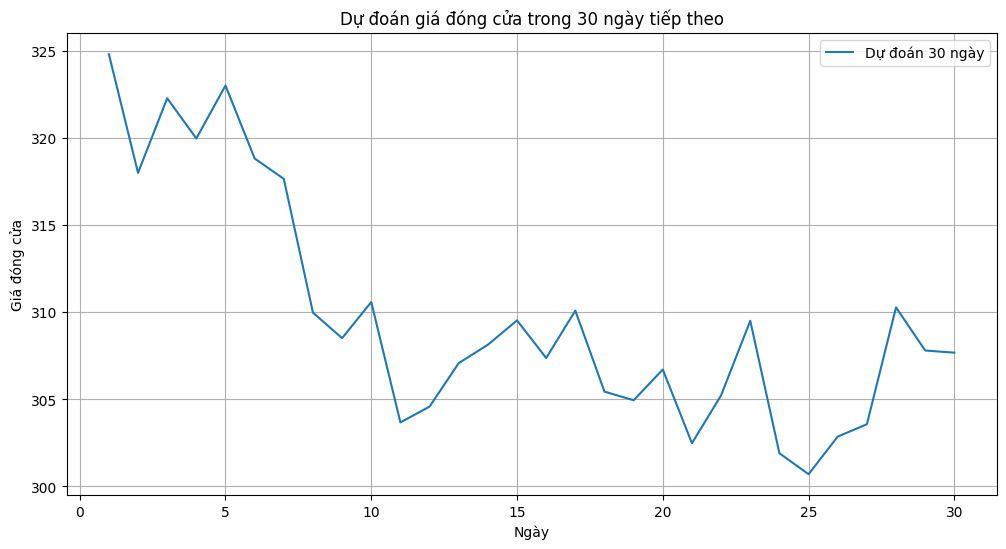

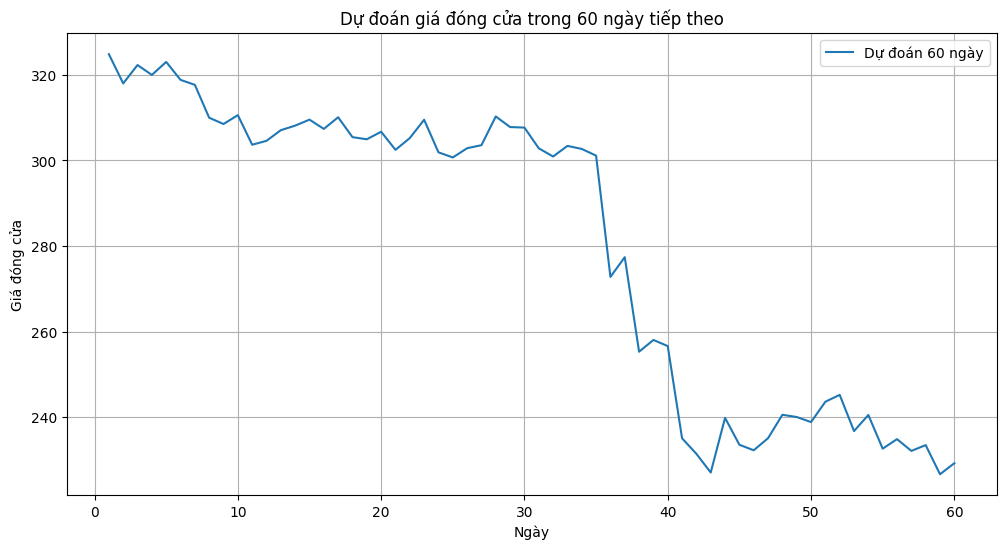

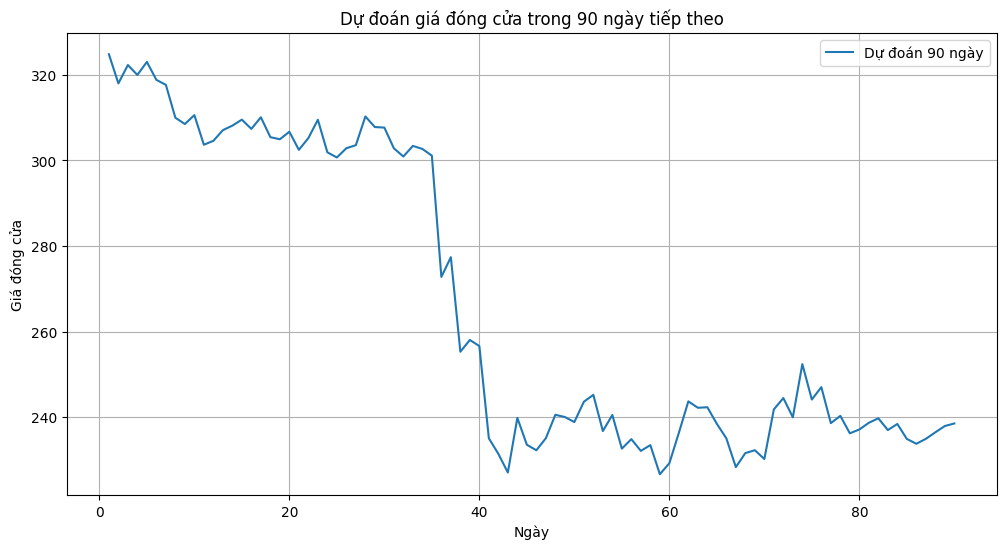

In [ ]:
import matplotlib.pyplot as plt

# Giả sử y_pred_30 có kích thước (352, 1)
y_pred_30 = y_pred_30[:30]  # Cắt ngắn y_pred_30 để có kích thước (30,)

plt.figure(figsize=(12, 6))
x = np.arange(1, 31)
plt.plot(x, y_pred_30, label='Dự đoán 30 ngày')
plt.title('Dự đoán giá đóng cửa trong 30 ngày tiếp theo')
plt.xlabel('Ngày')
plt.ylabel('Giá đóng cửa')
plt.legend()
plt.grid()
plt.show()

# Vẽ biểu đồ dự đoán 60 ngày
y_pred_60 = y_pred_60[:60]  # Cắt ngắn y_pred_60 để có kích thước (60,)

plt.figure(figsize=(12, 6))
x = np.arange(1, 61)
plt.plot(x, y_pred_60, label='Dự đoán 60 ngày')
plt.title('Dự đoán giá đóng cửa trong 60 ngày tiếp theo')
plt.xlabel('Ngày')
plt.ylabel('Giá đóng cửa')
plt.legend()
plt.grid()
plt.show()

# Vẽ biểu đồ dự đoán 90 ngày
y_pred_90 = y_pred_90[:90]  # Cắt ngắn y_pred_30 để có kích thước (30,)

plt.figure(figsize=(12, 6))
x = np.arange(1, 91)
plt.plot(x, y_pred_90, label='Dự đoán 90 ngày')
plt.title('Dự đoán giá đóng cửa trong 90 ngày tiếp theo')
plt.xlabel('Ngày')
plt.ylabel('Giá đóng cửa')
plt.legend()
plt.grid()
plt.show()